In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing._data import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [ ]:
TrainingData = pd.read_pickle('../data/02 Processed/train.pkl')
FinalTestData = pd.read_pickle('../data/02 Processed/testData.pkl')
FinalTestData.drop(columns = 'usage', inplace = True)
# s = TrainingData.iloc[:1000].copy()
# del TrainingData
# TrainingData = s.copy()
# del s

FinalTestData.shape, TrainingData.shape
TrainingDataCheckPoint = TrainingData.copy()

In [8]:
big,small = train_test_split(TrainingData, test_size=0.02, stratify=TrainingData['emotion'], random_state=42)

<Axes: xlabel='emotion'>

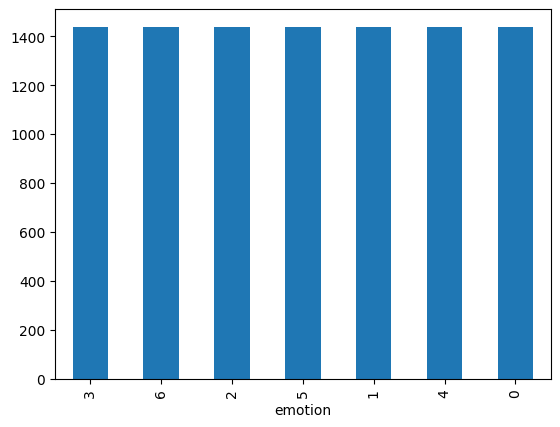

In [11]:
small.emotion.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

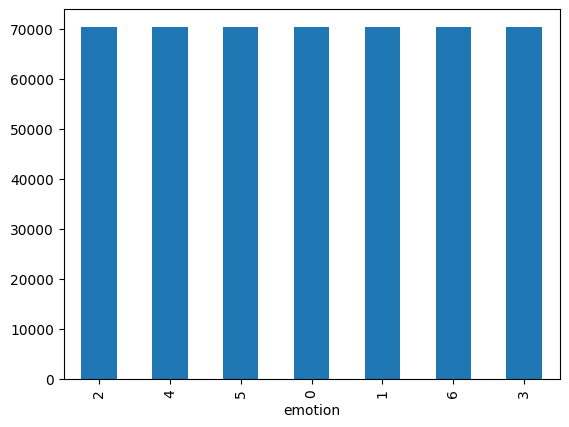

In [12]:
big.emotion.value_counts().plot(kind='bar')

In [13]:
TrainingData = small

In [89]:
TrainingData = TrainingData.iloc[:5]

In [101]:
TrainingData = small

In [102]:
class CustomScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
        self.__mean = None
        self.__std = None
        self.__fitted = False
    
    @property
    def _fitted(self)->bool:
        return self.__fitted
    
    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _mean(self)->np.ndarray:
        '''
        mean of the passed data
        '''
        if self.__mean is None:
            raise AttributeError("The 'fit' method must be called before accessing the mean.")
        return self.__mean
    
    @property
    def _std(self)->np.ndarray:
        '''
        std of the passed data
        '''
        if self.__std is None:
            raise AttributeError("The 'fit' method must be called before accessing the std.")
        return self.__std

    def fit(self, X: np.ndarray)-> 'CustomScaler':
        self._fitted = True
        self.__mean = X.mean(axis=0)
        self.__std = X.std(axis=0)
        return self
    
    def transform(self, X: np.ndarray)-> np.ndarray:
        newX = X - self._mean
        newX = (newX / self._std) * self.sigma
        return newX+self.mu

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        newX = X - self.mu
        newX = (newX / self._std) * self.sigma
        return newX + self._mean

class Data(Dataset):
    _identityFunc = lambda x: x
    def __init__(self,data:pd.DataFrame, transform:transforms = None, scaler:BaseEstimator = None):
        # making them private so can't be altered
        if not scaler:
            scaler = CustomScaler(0, 0.25)

        self.__transform = transform if transform else Data._identityFunc
        self.__Y = data['emotion'].astype(int).values.tolist()
        self.__X = data.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48)
        self.__len = data.shape[0]
        try:
            self.__X = scaler.fit_transform(self.__X).astype(np.float32)
        except AttributeError:
            print("Already fit")
            self.__X = scaler.transform(self.__X).astype(np.float32)

    def __len__(self)->int:
        return self.__len

    def __getitem__(self, index)->tuple[np.ndarray,np.ndarray]:
        img:np.ndarray = self.__X[index]
        emotion:int = self.__Y[index]
        label = np.zeros((7,), dtype=np.float32)
        label[emotion] = 1
        return self.__transform(img), label

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 12 * 12, 256),
            nn.LeakyReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 100),
            nn.Sigmoid()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    


In [122]:

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get accuracy
        predicted = outputs.argmax(axis=1)
        target = labels.argmax(axis=1)
        correct = (predicted == target).sum().item()
        accuracy = correct / labels.size(0)
    return running_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          predicted = outputs.argmax(axis=1)
          total += labels.size(0)
          correct += (predicted == labels.argmax(axis = 1)).sum().item()

    return running_loss / len(dataloader), correct / total

In [104]:
class CustomLoss(nn.Module):
    '''
    nn.CrossEntropyLosss is annoying me the way it expects labels
    it also does the softmax part itself.

    this class expects two R^n vectors or two arrays of R^n vectors
    it then penalises the difference using negative log liklihood
    '''
    def __init__(self):
        super(CustomLoss, self).__init__()
    def forward(self, probabilites:torch.Tensor, target:torch.Tensor)->torch.Tensor:
        '''
        probabilites: R^n
        target: R^n
        '''
        # print(probabilites)
        # print(target)
        # print(probabilites.shape)
        # print(target.shape)
        return -torch.sum(target * torch.log(probabilites + 1e-10), dim=1).mean()

In [ ]:
transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
scaler = CustomScaler(0, 0.25) #<- Pretty good - 37% accuracy on test set, 95% on training set

scaler.fit(TrainingData.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48))

print('making dataset')
train_data = Data(TrainingData, transform=transformers, scaler=scaler)
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
train_loader = DataLoader(train_data, shuffle = True, batch_size=503370)
test_loader = DataLoader(test_data, batch_size=7178, shuffle = True)

print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

print('backward')
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

fitting scaler
making dataset
Already fit
Already fit
making dataloader
making model
backward
Epoch [1/100],     Train Loss: 1.9759,     Test Loss: 2.0018,     Accuracy: 0.2288
Epoch [2/100],     Train Loss: 2.2109,     Test Loss: 1.9555,     Accuracy: 0.1115
Epoch [3/100],     Train Loss: 1.9549,     Test Loss: 1.9796,     Accuracy: 0.0152
Epoch [4/100],     Train Loss: 1.9487,     Test Loss: 1.9580,     Accuracy: 0.0152
Epoch [5/100],     Train Loss: 1.9485,     Test Loss: 1.9412,     Accuracy: 0.2335
Epoch [6/100],     Train Loss: 1.9454,     Test Loss: 1.9340,     Accuracy: 0.1861
Epoch [7/100],     Train Loss: 1.9438,     Test Loss: 1.9321,     Accuracy: 0.1747
Epoch [8/100],     Train Loss: 1.9420,     Test Loss: 1.9350,     Accuracy: 0.1651
Epoch [9/100],     Train Loss: 1.9372,     Test Loss: 1.9383,     Accuracy: 0.1806
Epoch [10/100],     Train Loss: 1.9287,     Test Loss: 1.9316,     Accuracy: 0.1780
Epoch [11/100],     Train Loss: 1.9223,     Test Loss: 1.9225,     Accuracy

In [ ]:
transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
# scaler = CustomScaler(0, 0.25) #<- Pretty good - 37% accuracy on test set, 95% on training set
scaler = CustomScaler(0.5, 0.125) #<- Pretty good - 37% accuracy on test set, 95% on training set

scaler.fit(TrainingData.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48))

print('making dataset')
train_data = Data(TrainingData, transform=transformers, scaler=scaler)
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
train_loader = DataLoader(train_data, shuffle = True, batch_size=503370)
test_loader = DataLoader(test_data, batch_size=7178, shuffle = True)

print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

print('backward')
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

fitting scaler
making dataset
Already fit
Already fit
making dataloader
making model
backward
Epoch [1/100],     Train Loss: 1.9550,     Test Loss: 2.2729,     Accuracy: 0.1427
Epoch [2/100],     Train Loss: 2.2098,     Test Loss: 2.1075,     Accuracy: 0.0152
Epoch [3/100],     Train Loss: 2.0309,     Test Loss: 1.9840,     Accuracy: 0.0152
Epoch [4/100],     Train Loss: 1.9657,     Test Loss: 1.9238,     Accuracy: 0.2505
Epoch [5/100],     Train Loss: 1.9596,     Test Loss: 1.8934,     Accuracy: 0.2505


In [124]:
for epoch in range(10):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Train Accuracy: {train_accuracy:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

Epoch [1/100],     Train Loss: 0.2712,     Train Accuracy: 0.9385,     Test Loss: 2.4787,     Accuracy: 0.3473
Epoch [2/100],     Train Loss: 0.2572,     Train Accuracy: 0.9413,     Test Loss: 2.4999,     Accuracy: 0.3486
Epoch [3/100],     Train Loss: 0.2374,     Train Accuracy: 0.9460,     Test Loss: 2.4694,     Accuracy: 0.3575
Epoch [4/100],     Train Loss: 0.2201,     Train Accuracy: 0.9520,     Test Loss: 2.5346,     Accuracy: 0.3449


KeyboardInterrupt: 

In [113]:
# for images, labels in train_loader:
#     print(1)

y = model(images).argmax(axis=1)

In [115]:
yhat = labels.argmax(axis=1)

In [117]:
yhat

tensor([4, 3, 2,  ..., 4, 3, 1])

In [121]:
(y == yhat).sum().item()/len(yhat)

0.9295788637266588